# Import Libraries

In [131]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import cv2
import albumentations as A
import time
import os

from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url
from datasets import load_metric

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device.upper()}" device.')

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

num_classes = 23

Currently using "CUDA" device.


# Read the data into a dataframe

In [132]:
images_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
color_masks_path = r'../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/'
masks_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

images = glob(images_path + '*.jpg')
colored_masks = glob(color_masks_path + '*.png')
masks = glob(masks_path + '*.png')

images = sorted([str(p) for p in images])
colored_masks = sorted([str(p) for p in colored_masks])
masks = sorted([str(p) for p in masks])

path_df = pd.DataFrame({'image': images, 'color_mask': colored_masks, 'mask': masks})
path_df.sample(2)

labels = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
label_to_id = {v: k for k, v in enumerate(labels['name'].unique())}
id_to_label = {v: k for k, v in label_to_id.items()}

palette = []
for i in range(num_classes):
    color = labels.iloc[i, 1:].values.tolist()
    palette.append(color)

# Build the pytorch dataset object

In [133]:
class DroneTestDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
      
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.loc[idx].squeeze()
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        color_mask = cv2.imread(row['color_mask'])
        color_mask = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask, color_mask


t_test = A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(path_df, transform=t_test)

# Load models

## SegFormer

In [134]:
PATH_SEGFORMER = f"../input/semanticdronedatasetmodels/SegFormer.bin"
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=num_classes+1, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,)

def load_model_segformer(path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

segformer = load_model_segformer(PATH_SEGFORMER)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.b

## U-Net 

In [135]:
PATH_UNET = f"../input/semanticdronedatasetmodels/Unet-EfficientNet.bin"

def build_model_Unet():
    model = smp.Unet(
        'efficientnet-b0', encoder_weights=None, classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
    )
    model.to(device)
    return model

def load_model_Unet(path):
    model = build_model_Unet()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

unet = load_model_Unet(PATH_UNET)

# Inference

In [136]:
def predict_image_mask_unet(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad(): 
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        output = model(image)
        seg = torch.argmax(output, dim=1)
        seg = seg.cpu().squeeze(0)        
    return seg

In [137]:
@torch.no_grad()
def predict_image_mask_segformer(model, image, mask):
    model.eval()
    model.to(device)
    feature_extractor = SegformerFeatureExtractor(reduce_labels=True) # remove background class
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(logits,
                                                 size=image.size[::-1],
                                                 mode='bilinear',
                                                 align_corners=False)
    seg = upsampled_logits.argmax(dim=1)[0]
    return seg

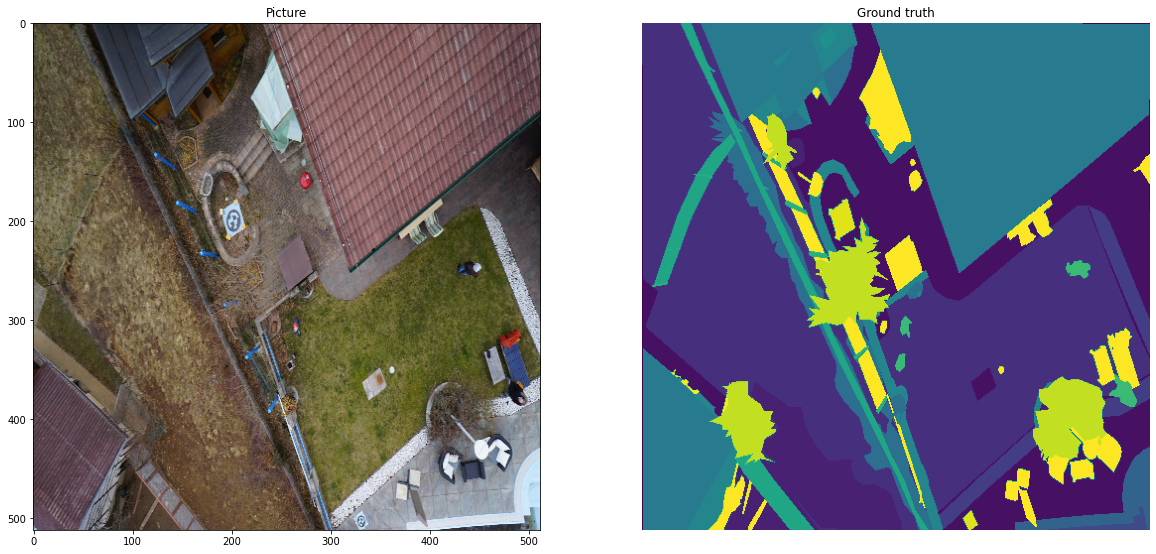

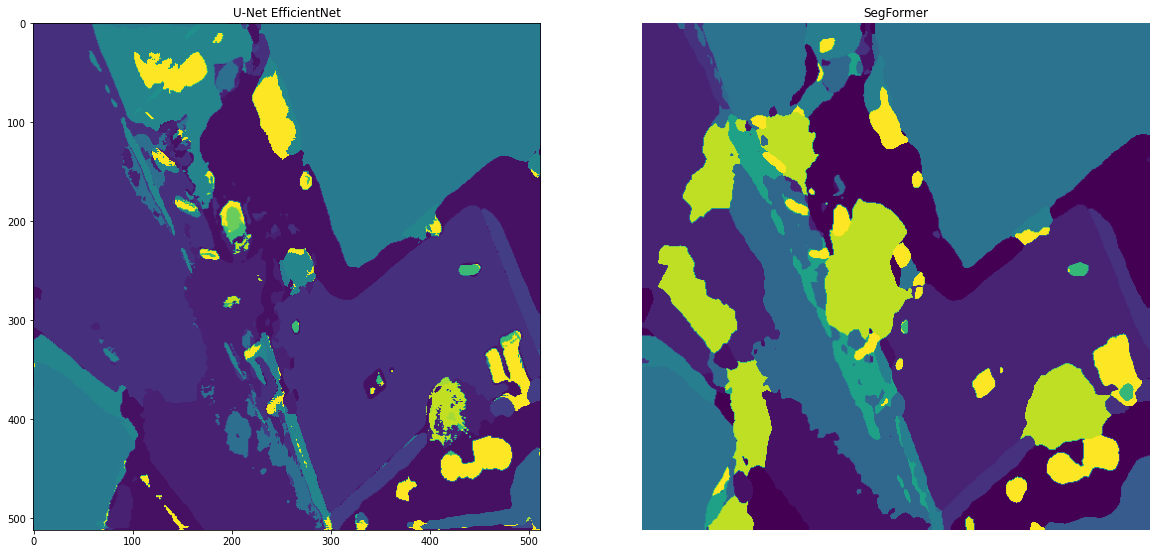

In [138]:
import random
image, mask, color_mask = test_set[random.randint(0,len(path_df))]

pred_mask_unet= predict_image_mask_unet(unet, image, mask)
pred_mask_segformer = predict_image_mask_segformer(segformer, image, mask)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()


figg, (ax3, ax4) = plt.subplots(1,2, figsize=(20,10))
ax3.imshow(pred_mask_unet)
ax3.set_title('U-Net EfficientNet');

ax4.imshow(pred_mask_segformer)
ax4.set_title('SegFormer')
ax4.set_axis_off()

